In [1]:
import mesa
import numpy as np
from enum import Enum
import uuid
import random

def new_uuid():
    # Generate a UUID
    unique_id = uuid.uuid4()

    # Convert the UUID to an integer
    int_uuid = int(unique_id.int)

    return int_uuid

In [2]:
# class FireAgent(mesa.Agent):
#     def __init__(self, unique_id, model, state: int):
#         super().__init__(unique_id, model)
#         # Agent może być w jednym z 6 stanów:
#         # 0 - brak pożaru
#         # 1 - wczesny ogień
#         # 2 - średni ogień
#         # 3 - pełny ogień
#         # 4 - ekstremalny ogień
#         # 5 - obszar spalony (obszar spalony nie może podpalić się po raz kolejny, gdyż całe paliwo zostało spalone) 
#         self.state = state
#         self.time_step = 0
#         self.type = "Fire"

#     def extinguised(self):
#         if self.time_step <= 0:
#             self.time_step = 0
#             self.state = 0
#             return True
#         else:
#             return False
        
#     def step(self):
#         if 0 < self.state < 5:
#             self.time_step += 0.5
#         cellmates = self.model.grid.get_cell_list_contents([self.pos])
#         firefighting_units = 0
#         for c in cellmates:
#             if c.type == "FireFighter":
#                 firefighting_units += 1
                
#         if self.state == 1:
#             self.time_step -= firefighting_units*2
#             if self.extinguised():
#                 return
#             if self.time_step >= 20:
#                 self.time_step = 0
#                 self.state = 2
                
#         elif self.state == 2:
#             self.time_step -= firefighting_units
#             if self.extinguised():
#                 return
#             if self.time_step >= 10:
#                 self.time_step = 0
#                 self.state = 3
                
#         elif self.state == 3:
#             self.time_step -= firefighting_units*0.5
#             if self.extinguised():
#                 return
#             neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
#             for n in neighborhood:
#                 agents_n = self.model.grid.get_cell_list_contents([(n[0], n[1])])
#                 break_search = False
#                 for c in agents_n:
#                     if c.type == "Fire" and c.state == 0:
#                         c.state = 1
#                         c.time_step = 0
#                         break_search = True
#                         break
#                 if break_search:
#                     break
#             if self.time_step >= 10:
#                 self.time_step = 0
#                 self.state = 4
                
#         elif self.state == 4:
#             self.time_step -= firefighting_units*0.25
#             if self.extinguised():
#                 return
#             neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
#             for n in neighborhood:
#                 agents_n = self.model.grid.get_cell_list_contents([(n[0], n[1])])
#                 for c in cellmates:
#                     if c.type == "Fire" and c.state < 4:
#                         c.state += 1
#                         c.time_step = 0
#                         break
#             if self.time_step >= 10:
#                 self.time_step = 0
#                 self.state = 5

# class FireFighterAgent(mesa.Agent):
#     def __init__(self, unique_id, model):
#         super().__init__(unique_id, model)
#         self.type = "FireFighter"
        
#     def step(self):
#         pass

In [2]:
class FireAgent(mesa.Agent):
    def __init__(self, unique_id, model, state: int):
        super().__init__(unique_id, model)
        # Agent może być w jednym z 6 stanów:
        # 0 - brak pożaru
        # 1 - wczesny ogień
        # 2 - średni ogień
        # 3 - pełny ogień
        # 4 - ekstremalny ogień
        # 5 - obszar spalony (obszar spalony nie może podpalić się po raz kolejny, gdyż całe paliwo zostało spalone) 
        self.state = state
        self.type = "Fire"
        self.fuel = 70
        self.time_in_state = 0
        self.max_time_in_step = 10

    def extinguised(self):
        if self.time_step <= 0:
            self.time_step = 0
            self.state = 0
            return True
        else:
            return False
        
    def check_if_burned(self):
        if self.fuel <= 0:
            self.fuel = 0
            self.state = 5
    
    def make_damage(self):
        if self.state == 1:
            self.fuel -= 0.5
        elif self.state == 2:
            self.fuel -= 1
        elif self.state == 3:
            self.fuel -= 2
        elif self.state == 4:
            self.fuel -= 4
    
    def apply_firefighters(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        firefighting_units = 0
        for c in cellmates:
            if c.type == "FireFighter":
                firefighting_units += 1
        
        if self.state == 1:
            # one firefighter needed to decrease time_in_state during step
            self.time_in_state -= firefighting_units*1.5
        elif self.state == 2:
            # two firefighters needed to decrease time_in_state during step
            self.time_in_state -= firefighting_units*1
        elif self.state == 3:
            # three firefighters needed to decrease time_in_state during step
            self.time_in_state -= firefighting_units*0.5
        elif self.state == 4:
            # four firefighters needed to decrease time_in_state during step
            self.time_in_state -= firefighting_units*0.3

    def change_state(self):
        if self.time_in_state > self.max_time_in_step:
            if self.state < 5:
                self.state += 1
                self.time_in_state = 0
        elif self.time_in_state < 0:
            if self.state > 0:
                self.state -= 1
                self.time_in_state = self.max_time_in_step

    def get_neighborhood(self):
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        fire_agents = []
        for n in neighborhood:
            agents_n = self.model.grid.get_cell_list_contents([(n[0], n[1])])
            for c in agents_n:
                if c.type == "Fire":
                   fire_agents.append(c)
        return fire_agents

    def spread_fire(self):
        neighborhood = self.get_neighborhood()
        sampled_neighbours = []
        if self.state == 3:
            sampled_neighbours = random.sample(neighborhood, 1)
        if self.state == 4:
            sampled_neighbours = random.sample(neighborhood, 2)
        for n in sampled_neighbours:
            if n.state == 0:
                n.state = 1
                n.time_in_state = 0
            elif n.state < 5:
                n.time_in_state += 1

    def step(self):
        if 0 < self.state < 5:
            self.make_damage()
            self.apply_firefighters()
            self.change_state()
            self.spread_fire()
            self.time_in_state += 1
        self.check_if_burned()

class FireFighterAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = "FireFighter"
        
    def step(self):
        pass

In [3]:
class FireControllerAgentModel(mesa.Model):
    def __init__(self, width, height, fire_fighters, fire_agents_values: list):
        """
        width, height - rozmiary lasu (dla symulacji przyjmujemy rozmiar 10x10
        
        fire_fighters - ilość jednostek straży pożarnej, jakie FCA ma do dyspozycji
        
        fire_agents_values - lista wartości ze zbioru {1,2,3,4} określająca początkowe wartości pożaru w losowo wybranych komórkach.
        Maksymalna długość listy to 100 (tyle ile mamy komórek w siatce 10x10). Przykładowo, dla listy [1,1,3,2], cztery losowo 
        wybrane komórki zostaną zainicjalizowane właśnie takimi wartościami poziomu pożaru
        """
        self.width = width
        self.height = height
        self.fire_fighters = fire_fighters
        self.grid = mesa.space.MultiGrid(width=width, height=height, torus=False)
        self.schedule = mesa.time.RandomActivation(self)
        self.firefighters_exposure_to_fire = 0

        all_indices = [(i, j) for i in range(width) for j in range(height)]
        fire_cells = random.sample(all_indices, len(fire_agents_values))
        no_fire_cells = [index for index in all_indices if index not in fire_cells]
        for i, index in enumerate(fire_cells):
            a = FireAgent(new_uuid(), self, fire_agents_values[i])
            self.grid.place_agent(a, index)
            self.schedule.add(a)
        for i, index in enumerate(no_fire_cells):
            a = FireAgent(new_uuid(), self, 0)
            self.grid.place_agent(a, index)
            self.schedule.add(a)

    def step(self):
        self.assign_firefighters_to_grid()
        self.firefighters_exposure_to_fire += self.get_firefighters_exposure()
        self.schedule.step()

    def set_fire_fighters(self, fire_fighters):
        self.fire_fighters = fire_fighters

    def print_grid(self):
        values = np.zeros((self.width, self.height))
        for x in range(self.width):
            for y in range(self.height):
                fire = self.get_fire_agent(x, y)
                fighters = self.get_firefighter_agent(x, y)
                values[x,y] = fire.state + len(fighters)*10
        print(values)

    def get_total_fire_level(self):
        result = 0
        for x in range(self.width):
            for y in range(self.height):
                fire = self.get_fire_agent(x, y)
                result += fire.state if fire.state < 5 else 0
        return result

    def get_total_burned_level(self):
        result = 0
        for x in range(self.width):
            for y in range(self.height):
                fire = self.get_fire_agent(x, y)
                result += fire.state if fire.state == 5 else 0
        return result
    
    def get_remaining_fuel(self):
        result = 0
        for x in range(self.width):
            for y in range(self.height):
                fire = self.get_fire_agent(x, y)
                result += fire.fuel
        return result

    def get_fire_agent(self, x, y):
        agents = self.grid.get_cell_list_contents([(x,y)])
        for a in agents:
            if a.type == "Fire":
                return a
            
    def get_firefighter_agent(self, x, y):
        agents = self.grid.get_cell_list_contents([(x,y)])
        result = []
        for a in agents:
            if a.type == "FireFighter":
                result.append(a)
        return result
    
    def get_all_firefighters(self):
        result = []
        for x in range(self.width):
            for y in range(self.height):
                result += self.get_firefighter_agent(x, y)
        return result
    
    def get_firefighters_exposure(self):
        result = 0
        for x in range(self.width):
            for y in range(self.height):
                all_agents = self.grid.get_cell_list_contents([(x,y)])
                firefighters = len(all_agents)-1 #number of firefighters in cell is equal to all agents minus fire agent
                result += firefighters*self.get_fire_agent(x, y).state
        return result

    def delete_firefighters(self):
        for x in range(self.width):
            for y in range(self.height):
                agents = self.grid.get_cell_list_contents([(x,y)])
                for a in agents:
                    if a.type == "FireFighter":
                        self.schedule.remove(a)
                        self.grid.remove_agent(a)
        
    def assign_firefighters_to_grid(self):
        self.delete_firefighters()
        values = np.zeros((self.width, self.height))
        for x in range(self.width):
            for y in range(self.height):
                fire = self.get_fire_agent(x, y)
                values[x,y] = fire.state if fire.state < 5 else 0
                
        # Get the indices in descending order of values
        indices = np.argsort(values.ravel())[::-1]
        # Convert the 1D indices to 2D indices
        row_indices, col_indices = np.unravel_index(indices, values.shape)
        # Filter indices where the value is greater than zero
        non_zero_indices = (values[row_indices, col_indices] > 0).nonzero()
        # Get the final indices
        sorted_indices = []
        for x, y in zip(row_indices[non_zero_indices], col_indices[non_zero_indices]):
            sorted_indices.append((x,y))

        available_firefighters = self.fire_fighters
        while available_firefighters > 0:
            for index in sorted_indices:
                x, y = index
                if self.get_fire_agent(x,y).state == 4:
                    new_firefighters = min(4, available_firefighters)
                elif self.get_fire_agent(x,y).state == 3:
                    new_firefighters = min(3, available_firefighters)
                elif self.get_fire_agent(x,y).state == 2:
                    new_firefighters = min(2, available_firefighters)
                else:
                    new_firefighters = min(1, available_firefighters) 
                for _ in range(new_firefighters):
                    a = FireFighterAgent(new_uuid(), self)
                    self.grid.place_agent(a, (x, y))
                    self.schedule.add(a)
                available_firefighters -= new_firefighters
                if available_firefighters == 0:
                    break
        

In [15]:
rand_fire_fighters = random.randint(1, 50)

starter_model = FireControllerAgentModel(width=10, height=10, fire_fighters=rand_fire_fighters, fire_agents_values=[1, 1, 3, 4, 4, 4, 2, 2, 2, 1])
#print(70*100)
print("Starter model:")
i = 0
while starter_model.get_total_fire_level() > 0:
    starter_model.step()
    fuel = starter_model.get_remaining_fuel()
    exposure = starter_model.firefighters_exposure_to_fire
    print(f"step: {i}, fuel: {fuel}, exposure: {exposure}, fire:{starter_model.get_total_fire_level()}, firefighters: {starter_model.fire_fighters}")
    i += 1

print(f"Remaining fuel: {starter_model.get_remaining_fuel()-starter_model.firefighters_exposure_to_fire}")
print(f"Total burned: {starter_model.get_total_burned_level()}")

Starter model:
step: 0, fuel: 6980.5, exposure: 148, fire:17, firefighters: 49
step: 1, fuel: 6970.0, exposure: 257, fire:16, firefighters: 49
step: 2, fuel: 6959.5, exposure: 368, fire:17, firefighters: 49
step: 3, fuel: 6949.5, exposure: 477, fire:9, firefighters: 49
step: 4, fuel: 6945.0, exposure: 560, fire:5, firefighters: 49
step: 5, fuel: 6942.5, exposure: 629, fire:1, firefighters: 49
step: 6, fuel: 6942.0, exposure: 678, fire:0, firefighters: 49
Remaining fuel: 6264.0
Total burned: 0


In [4]:
# Algorytm przed modyfikacją
class QLearning():
    def __init__(self):
        self.width = 10
        self.height = 10
        self.fire_fighters = 51
        self.actions = [i for i in range(self.fire_fighters)]
        self.states = [20*(i+1) for i in range(25)]
        self.q_table = np.zeros((len(self.states), len(self.actions)))

    def run(self, alpha=0.1, gamma=0.9, epsilon=0.6, epsilon_decay=0.2, episodes=1000):
        for episode in range(episodes):
            if episode%100 == 0:
                print(f"Episode {episode}")
            # generated initial state shouldn't take into account burned places
            state = random.randint(0,len(self.states)-1)
            while self.states[state] > 400:
                state -=1
            total_fire = 400
            if state == 0:
                fire_list = self.generate_fire_list(1, self.states[state])
            else:
                fire_list = self.generate_fire_list(self.states[state-1]+1, self.states[state])
            self.model = FireControllerAgentModel(width=self.width, height=self.height, 
                                         fire_fighters=self.fire_fighters, fire_agents_values=fire_list)
            while total_fire > 0:
                if np.random.rand() < epsilon:
                    action = np.random.randint(0,len(self.actions)-1)
                else:
                    action = np.argmax(self.q_table[state])
                    
                next_state, reward, total_fire = self.take_action(state, action)
                self.q_table[state, action] = (1 - alpha) * self.q_table[state, action] + \
                                alpha * (reward + gamma * np.max(self.q_table[next_state]))
                state = next_state
            epsilon *= epsilon_decay

    def fire_level_to_state(self, fire_level):
        result = 0
        for i in range(len(self.states)):
            if fire_level <= self.states[i]:
                result = i
                break
        return result

    def take_action(self, state, action):
        self.model.set_fire_fighters(action)
        while True:
            self.model.step()
            total_fire = self.model.get_total_fire_level()
            if total_fire == 0:
                next_state = 0
                break
            next_state = self.fire_level_to_state(total_fire)
            if next_state != state:
                break
        reward = self.model.get_remaining_fuel()-self.model.firefighters_exposure_to_fire
        return next_state, reward, total_fire
                
    def generate_fire_list(self, range_start, range_end, max_length=100):
        digit_list = []
        
        for i in range(max_length):
            digit = random.randint(1, 4)
            digit_list.append(digit)
            if sum(digit_list) >= range_end:
                digit_list.pop()
                break
            if range_start < sum(digit_list) <= range_end:
                if random.random()<0.3:
                    break
        i = 0
        while sum(digit_list) < range_start+1:
            new_val = 4-digit_list[i]
            digit_list[i] += new_val
            i += 1
        return digit_list
        

In [5]:
# Nowy algorytm - dodany parametr episodes_with_random_action
class QLearning():
    def __init__(self):
        self.width = 10
        self.height = 10
        self.fire_fighters = 51
        self.actions = [i for i in range(self.fire_fighters)]
        self.states = [20*(i+1) for i in range(25)]
        self.q_table = np.zeros((len(self.states), len(self.actions)))

    def run(self, alpha=0.1, gamma=0.9, epsilon=0.6, epsilon_decay=0.2, episodes_with_random_action=1000, rest_episodes=1000):
        for episode in range(episodes_with_random_action+rest_episodes):
            if episode%100 == 0:
                print(f"Episode {episode}")
            # generated initial state shouldn't take into account burned places
            state = random.randint(0,len(self.states)-1)
            while self.states[state] > 400:
                state -=1
            total_fire = 400
            if state == 0:
                fire_list = self.generate_fire_list(1, self.states[state])
            else:
                fire_list = self.generate_fire_list(self.states[state-1]+1, self.states[state])
            self.model = FireControllerAgentModel(width=self.width, height=self.height, 
                                         fire_fighters=self.fire_fighters, fire_agents_values=fire_list)
            while total_fire > 0:
                if episode <= episodes_with_random_action or np.random.rand() < epsilon:
                    action = np.random.randint(0,len(self.actions)-1)
                else:
                    action = np.argmax(self.q_table[state])
                    
                next_state, reward, total_fire = self.take_action(state, action)
                self.q_table[state, action] = (1 - alpha) * self.q_table[state, action] + \
                                alpha * (reward + gamma * np.max(self.q_table[next_state]))
                state = next_state
            if episode > episodes_with_random_action:
                epsilon *= epsilon_decay

    def fire_level_to_state(self, fire_level):
        result = 0
        for i in range(len(self.states)):
            if fire_level <= self.states[i]:
                result = i
                break
        return result

    def take_action(self, state, action):
        self.model.set_fire_fighters(action)
        while True:
            self.model.step()
            total_fire = self.model.get_total_fire_level()
            if total_fire == 0:
                next_state = 0
                break
            next_state = self.fire_level_to_state(total_fire)
            if next_state != state:
                break
        reward = self.model.get_remaining_fuel()-self.model.firefighters_exposure_to_fire
        return next_state, reward, total_fire
                
    def generate_fire_list(self, range_start, range_end, max_length=100):
        digit_list = []
        
        for i in range(max_length):
            digit = random.randint(1, 4)
            digit_list.append(digit)
            if sum(digit_list) >= range_end:
                digit_list.pop()
                break
            if range_start < sum(digit_list) <= range_end:
                if random.random()<0.3:
                    break
        i = 0
        while sum(digit_list) < range_start+1:
            new_val = 4-digit_list[i]
            digit_list[i] += new_val
            i += 1
        return digit_list
        

In [165]:
q = QLearning()
q.run(episodes_with_random_action=500, rest_episodes=500, epsilon_decay=0.6, epsilon=0.9, alpha=0.55, gamma=0.9)

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900


In [166]:
for i in range(q.q_table.shape[0]):
    print(q.q_table[i])

[ 9257.79154475  7910.75219331 10048.25635299  9871.90604314
  9596.42717076  8917.52232919  9647.61501486  9928.57600759
  8787.75069827  8937.24826699  7821.68947296  9905.75635692
  8858.67571069  9140.40854608  9126.33678231  7968.76092859
  9647.43807827  9049.04473961  9848.92202475  9513.9474773
  8300.62333463  8293.02031357  9315.9444888   7408.96224469
  8914.80158633  8013.6357702  10104.46561555 10130.49077529
  8937.79473693  9971.06473154  7654.39899764  9998.98379182
  9087.93991194  5880.14691748  9734.04233416 10759.85625355
  9521.35244457  8914.00114697  7585.89454643  7882.46525707
  7351.47521228  7517.35442146  9923.29505535  9766.88374773
  9679.96025944  9609.46229784  8053.15594856  9585.17559951
 10162.99374812  8913.02406762     0.        ]
[ 8289.18660206  8887.08587185  8213.44311666  9411.5713165
 10539.20359275  8431.05404094 10829.95388368  9060.68026007
 10304.90315753 11568.2438446   8480.99748607  9739.55816869
 10121.34256649 10309.90087025  9674.581

In [5]:
class TrainedModel(FireControllerAgentModel):
    def __init__(self, fire_agents_values: list, q_table):
        super().__init__(width=10, height=10, fire_fighters=0, fire_agents_values=fire_agents_values)
        self.q_table = q_table
        self.actions = [i for i in range(51)]
        self.states = [20*(i+1) for i in range(25)]
        self.fire_fighters = self.calculate_next_firefighters()
        self.assign_firefighters_to_grid()

    def calculate_next_firefighters(self):
        fire_level = self.get_total_fire_level()
        state = 0
        for i in range(len(self.states)):
            if fire_level <= self.states[i]:
                state = i
                break
        fire_fighters = np.argmax(self.q_table[state])
        return fire_fighters
        
    def step(self):
        self.assign_firefighters_to_grid()
        self.firefighters_exposure_to_fire += self.get_firefighters_exposure()
        self.schedule.step()
        self.fire_fighters = self.calculate_next_firefighters()
    

In [167]:
trained_model = TrainedModel([1, 1, 3, 4, 4, 4, 2, 2, 2, 1], q.q_table)
print("Trained model:")
i = 0
while trained_model.get_total_fire_level() > 0:
    trained_model.step()
    fuel = trained_model.get_remaining_fuel()
    exposure = trained_model.firefighters_exposure_to_fire
    print(f"step: {i}, fuel: {fuel}, exposure: {exposure}, fire:{trained_model.get_total_fire_level()}, firefighters: {trained_model.fire_fighters}")
    i += 1

print(f"Remaining fuel: {trained_model.get_remaining_fuel()-trained_model.firefighters_exposure_to_fire}")
print(f"Total burned: {trained_model.get_total_burned_level()}")

Trained model:
step: 0, fuel: 6981.0, exposure: 36, fire:25, firefighters: 9
step: 1, fuel: 6965.5, exposure: 63, fire:29, firefighters: 9
step: 2, fuel: 6947.5, exposure: 94, fire:30, firefighters: 9
step: 3, fuel: 6930.5, exposure: 121, fire:33, firefighters: 9
step: 4, fuel: 6911.0, exposure: 152, fire:33, firefighters: 9
step: 5, fuel: 6892.0, exposure: 179, fire:34, firefighters: 9
step: 6, fuel: 6872.0, exposure: 210, fire:36, firefighters: 9
step: 7, fuel: 6852.0, exposure: 237, fire:37, firefighters: 9
step: 8, fuel: 6831.0, exposure: 264, fire:39, firefighters: 9
step: 9, fuel: 6809.5, exposure: 291, fire:42, firefighters: 19
step: 10, fuel: 6786.5, exposure: 341, fire:43, firefighters: 19
step: 11, fuel: 6763.0, exposure: 391, fire:51, firefighters: 19
step: 12, fuel: 6735.0, exposure: 444, fire:52, firefighters: 19
step: 13, fuel: 6707.0, exposure: 494, fire:53, firefighters: 19
step: 14, fuel: 6678.0, exposure: 544, fire:55, firefighters: 19
step: 15, fuel: 6649.0, exposure

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400


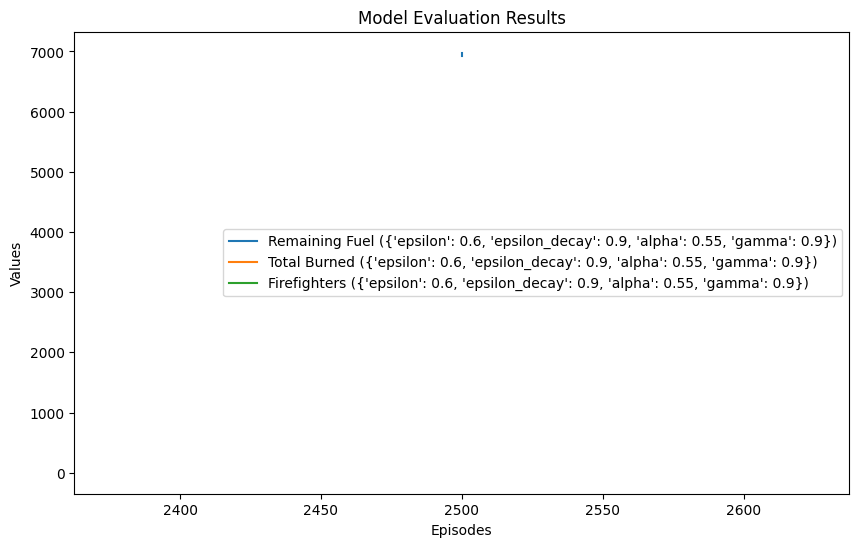

In [18]:
import csv
import matplotlib.pyplot as plt

param_sets = [
    #{'epsilon': 0.7, 'epsilon_decay': 0.95, 'alpha': 0.3, 'gamma': 0.8},
    #{'epsilon': 0.5, 'epsilon_decay': 0.99, 'alpha': 0.1, 'gamma': 0.95},
    {'epsilon': 0.6, 'epsilon_decay': 0.9, 'alpha': 0.55, 'gamma': 0.9}
]

episode_counts = [2500]

results_param_sets = []
results_episodes = []
results_remaining_fuel = []
results_exposure = []
results_total_burned = []
results_firefighters = []

for params in param_sets:
    results_param_sets.append(params)
    
    for episodes in episode_counts:
        q = QLearning()
        q.run(episodes_with_random_action=1500, rest_episodes=1000, **params)

        trained_model = TrainedModel([1, 1, 3, 4, 4, 4, 2, 2, 2, 1, 1, 1, 3], q.q_table)
        
        i = 0
        while trained_model.get_total_fire_level() > 0:
            trained_model.step()
            fuel = trained_model.get_remaining_fuel()
            exposure = trained_model.firefighters_exposure_to_fire()
            results_episodes.append(episodes)
            results_remaining_fuel.append(fuel)
            results_exposure.append(exposure)
            results_total_burned.append(trained_model.get_total_burned_level())
            results_firefighters.append(trained_model.fire_fighters)
            i += 1

with open('results.csv', mode='w', newline='') as csvfile:
    fieldnames = ['Param Set', 'Episodes', 'Remaining Fuel', 'Exposure', 'Total Burned']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(results_param_sets)):
        writer.writerow({
            'Param Set': results_param_sets[i],
            'Episodes': results_episodes[i],
            'Remaining Fuel': results_remaining_fuel[i],
            'Exposure': results_exposure[i],
            'Total Burned': results_total_burned[i],
            'Firefighters': results_firefighters[i]
        })

plt.figure(figsize=(10, 6))
for i in range(len(param_sets)):
    plt.plot(results_episodes[i::len(param_sets)], results_remaining_fuel[i::len(param_sets)], label=f'Remaining Fuel ({param_sets[i]})')
    plt.plot(results_episodes[i::len(param_sets)], results_total_burned[i::len(param_sets)], label=f'Total Burned ({param_sets[i]})')
    plt.plot(results_episodes[i::len(param_sets)], results_firefighters[i::len(param_sets)], label=f'Firefighters ({param_sets[i]})')

plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Model Evaluation Results')
plt.legend()
plt.savefig('evaluation_plot.png')
plt.show()

In [19]:
print(results_firefighters)
print(results_remaining_fuel)
print(results_total_burned)

steps = range(len(results_firefighters))


[46, 46, 46, 46, 46, 46, 46, 46]
[6978.5, 6967.5, 6956.0, 6944.5, 6935.0, 6929.5, 6926.0, 6924.5]
[0, 0, 0, 0, 0, 0, 0, 0]


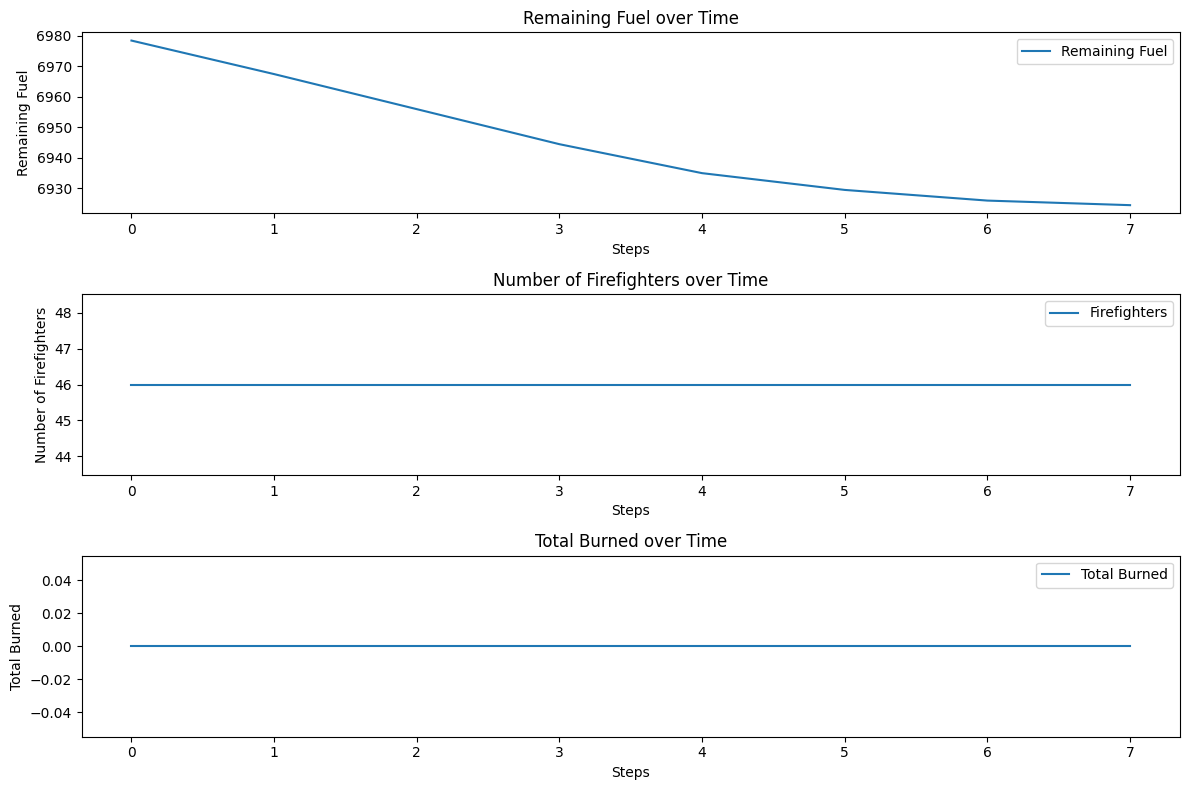

In [20]:
# Stwórz wykresy
plt.figure(figsize=(12, 8))

# Wykres pozostałego paliwa
plt.subplot(3, 1, 1)
plt.plot(steps, results_remaining_fuel, label='Remaining Fuel')
plt.title('Remaining Fuel over Time')
plt.xlabel('Steps')
plt.ylabel('Remaining Fuel')
plt.legend()

# Wykres użytych strażaków
plt.subplot(3, 1, 2)
plt.plot(steps, results_firefighters, label='Firefighters')
plt.title('Number of Firefighters over Time')
plt.xlabel('Steps')
plt.ylabel('Number of Firefighters')
plt.legend()

# Wykres całkowitego spalonego obszaru
plt.subplot(3, 1, 3)
plt.plot(steps, results_total_burned, label='Total Burned')
plt.title('Total Burned over Time')
plt.xlabel('Steps')
plt.ylabel('Total Burned')
plt.legend()

# Wyświetl wykresy
plt.tight_layout()
plt.show()

In [29]:
import csv
import numpy as np

all_results_episodes = []
all_results_remaining_fuel = []
all_results_exposure = []
all_results_total_burned = []

num_repetitions = 10

for _ in range(num_repetitions):
    for params in param_sets:
        results_episodes = []
        results_remaining_fuel = []
        results_exposure = []
        results_total_burned = []

        for episodes in episode_counts:
            q = QLearning()
            q.run(episodes=episodes, **params)

            trained_model = TrainedModel([1, 1, 3, 4, 4, 4, 2, 2, 2, 1, 1, 1, 3], q.q_table)

            i = 0
            while trained_model.get_total_fire_level() > 0:
                trained_model.step()
                fuel = trained_model.get_remaining_fuel()
                exposure = trained_model.firefighters_exposure_to_fire()
                results_episodes.append(episodes)
                results_remaining_fuel.append(fuel)
                results_exposure.append(exposure)
                results_total_burned.append(trained_model.get_total_burned_level())
                i += 1

        all_results_episodes.extend(results_episodes)
        all_results_remaining_fuel.extend(results_remaining_fuel)
        all_results_exposure.extend(results_exposure)
        all_results_total_burned.extend(results_total_burned)

with open('all_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Episodes', 'Remaining Fuel', 'Exposure', 'Total Burned'])

    for i in range(len(all_results_episodes)):
        episodes = all_results_episodes[i]
        remaining_fuel = all_results_remaining_fuel[i]
        exposure = all_results_exposure[i]
        total_burned = all_results_total_burned[i]

        writer.writerow([episodes, remaining_fuel, total_burned])

avg_remaining_fuel = np.mean(all_results_remaining_fuel)
avg_total_burned = np.mean(all_results_total_burned)

print(f'Average Remaining Fuel: {avg_remaining_fuel}')
print(f'Average Total Burned: {avg_total_burned}')


Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Epi